# Benders Decompositoon

## Master problem : 
To implement the Benders decomposition, we formulate a master problem as follows:
$$ 
    \begin{align}
        \min \quad & \phi =  \sum_{s \in \set{S}}\sum_{j \in \set{J}}c_{j}x_{j} + \sum_{s \in \set{S}}z_s & \\
        \text{s.t. } \quad & x_{j} \geq 0 \quad \forall\: j \in \set{J} &    \\
        & z_s \geq -10000000 \quad \forall\: s \in \set{S} \label{eq:lastconben} &
    \end{align}
$$
We add bounds to the variables to the master problem to keep it bounded

In [18]:
#Benders Decomposition
mp_obj_list = []
#Master problem
from pyomo.environ import *
from pyomo.opt import SolverFactory
import itertools
import numpy as np
import pandas as pd

mp = ConcreteModel()

# 5D Array
mp.gen = Set(initialize=[1, 2])  # Generators
mp.days = Set(initialize=[1, 2, 3])  # Demand scenario for time period 1

# Total Scenarios
file_path = 'newgenexp.xlsx'
sheet_name = 'DIC'  # Specify the sheet name or sheet number

# Load the data into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)
c = {}
for i in range(0,df.shape[0]):
    c[df['Generator'][i]] = df['Ammortized Fixed operating cost($)'][i]
mp.c = Param(mp.gen, initialize=c)  # Fixed cost per unit capacity of generator j

sheet_name = 'FIXOP'  # Specify the sheet name or sheet number

# Variables
mp.x = Var(mp.gen, domain=NonNegativeReals)  # Installed capacity of generator j
mp.z = Var(mp.days)  # Operating level of generator j
mp.constraint_base = Constraint(mp.days, rule=lambda mp, s:mp.z[s]>=-10**5)
mp.con_extra = ConstraintList()
# Objective function
def objective_rule(model):
    fixed_cost = 3*sum(model.c[j] * model.x[j] for j in model.gen)
    operating_cost = sum(model.z[s] for s in model.days) 
    return fixed_cost + operating_cost

mp.obj = Objective(rule=objective_rule, sense=minimize)






# Subproblem
We formulate subproblems as follows:
$$
    \begin{align}
       SP_s =  \min \quad & z_s =  \sum_{j \in \set{J}}c_{j}x_{j} + \sum_{i\in \set{I}}\left(\sum_{j \in \set{J}}\left(f_{i,j}y_{i,j} \right)+g_{s} \tilde{y}_{i}\right) & \\
        \text{s.t. } \quad & y_{i,j} \leq a_{s,i,j}x_{j}^* \quad \forall\: i \in \set{I},j \in \set{J} & \\
        & \sum_{j \in \set{J}}y_{i,j}+ \tilde{y}_{i} \geq d_{s,i}\quad \forall\: i \in \set{I}& \\
         & y_{i,j} \geq 0 \quad \forall\: i \in \set{I},j \in \set{J} & \\
          &  \tilde{y}_{i} \geq 0 \quad \forall\: i \in \set{I}&  
    \end{align}
$$
where $x^*$ is the solution obtained from the master problem.

In [19]:
file_path = 'newgenexp.xlsx'
sheet_name = 'FIXOP'  # Specify the sheet name or sheet number

# Load the data into a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)
f = {}
for i in range(0,df.shape[0]):
    f[(df['Generator'][i],df['Period'][i])] = df['FIXOP'][i]

sheet_name = 'Additional cost'  # Specify the sheet name or sheet number

df = pd.read_excel(file_path, sheet_name=sheet_name)
g = {}
for i in range(0,df.shape[0]):
    g[df['Day'][i]] = df['Cost'][i]

dem = {}

sheet_name = 'Demand'
df = pd.read_excel(file_path, sheet_name=sheet_name)
for i in range(0,df.shape[0]):
    dem[df['Day'][i],df['Period'][i]]= df['Demand (KWh)'][i]
    
av = {}    
sheet_name = 'Availability'
df = pd.read_excel(file_path, sheet_name=sheet_name)
for i in range(0,df.shape[0]):
    av[df['Day'][i],df['Period'][i],df['Generator'][i]]= df['Availibility'][i]
    
def subproblem_dual(xval,s):
    sp = ConcreteModel()
    sp.dual = Suffix(direction=Suffix.IMPORT)
    sp.gen = Set(initialize=[1, 2])  # Generators
    sp.Periods = Set(initialize=[1, 2, 3])
    sp.y = Var(sp.Periods,sp.gen, domain=NonNegativeReals)  # Operating level of generator j
    sp.y_purchased = Var(sp.Periods, domain=NonNegativeReals)  # Additional capacity purchased
    def objective_rule(model):
        operating_cost = sum(sum(f[j,i] * model.y[i,j] for j in model.gen) + g[s] * model.y_purchased[i] for i in model.Periods)
        return operating_cost
    
    sp.obj = Objective(rule=objective_rule, sense=minimize)
    
    # Constraints
    #Constraint for fixing x values
    

    # Demand satisfaction constraints
    def demand_satisfaction_rule(model, i):
        return -sum(model.y[i,j] for j in model.gen) - model.y_purchased[i] <=-dem[s,i] 
    sp.demand_satisfaction_constraint = Constraint(sp.Periods, rule=demand_satisfaction_rule)
    
    # Availability constraints
    def availability_rule(model, i, gen):
        return model.y[i,gen]- av[s,i,gen] * xval[gen-1] <= 0
    sp.availability_constraint = Constraint(sp.Periods, sp.gen, rule=availability_rule)
    dw = np.array([-dem[s,1],-dem[s,2],-dem[s,3],0,0,0,0,0,0])
    Bw = np.array([[0,0],[0,0],[0,0],[-av[s,1,1],0],[0,-av[s,1,2]],[-av[s,2,1],0],[0,-av[s,2,2]],[-av[s,3,1],0],[0,-av[s,3,2]]])
    return sp,dw,Bw
    

# Implementing Benders decomposition
We solve the master problem and subproblems iteratively, with Benders cuts added based on the dual obtained from the subproblems

In [20]:
opt = SolverFactory('gurobi')
opt.options['DualReductions'] = 0
days = [1,2,3]
periods = [1,2,3]
gen = [1,2]
UB = float('inf')
UB_list = []
while(1):
    results = opt.solve(mp)
    print(results.solver.termination_condition)
    mp_obj_list.append(mp.obj())
    x = [mp.x[1](),mp.x[2]()]
    c = 0
    msp_obj_val = []
    print(x)
    val = 0
    for s in days:
        sp,dw,Bw = subproblem_dual(x,s)
        opt.solve(sp)
        val = val+sp.obj()+sum(mp.c[j] * x[j-1] for j in sp.gen)
        
        a = []
        for i in periods:
            a.append(sp.dual[sp.demand_satisfaction_constraint[i]])
        for i in periods:
            for j in gen:
                a.append(sp.dual[sp.availability_constraint[i,j]])
                
        a = np.array(a)
        if(results.solver.termination_condition == TerminationCondition.infeasible):
            #print(a*dw)
            d = np.matmul(a,Bw)
            mp.con_extra.add(np.dot(a,dw)-sum(d[j-1]*mp.x[j] for j in gen) <= 0)
        else:
            if(sp.obj()<=mp.z[s]()):
                c = c+1
                msp_obj_val.append(sp.obj())
            else:       
                d = np.matmul(a,Bw)
                mp.con_extra.add(np.dot(a,dw)-sum(d[j-1]*mp.x[j] for j in gen) <=mp.z[s])
    UB = min(UB,val)
    UB_list.append(UB)
    if(c==3):
        print("yes")
        print(x)
        mp.pprint()
        print(mp.obj())
        break
        
        

optimal
[0.0, 0.0]
optimal
[5151.509393939395, 0.0]
optimal
[44.45373333333215, 3555.5386666666686]
optimal
[3283.748512396694, 0.0]
optimal
[2173.1751948051915, 1619.0285714285758]
optimal
[2658.1331597528683, 909.090909090909]
optimal
[2515.1521818181805, 909.090909090909]
optimal
[2515.1521818181805, 909.090909090909]
optimal
[2515.1521818181805, 909.090909090909]
yes
[2515.1521818181805, 909.090909090909]
2 Set Declarations
    days : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    gen : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {1, 2}

1 Param Declarations
    c : Size=2, Index=gen, Domain=Any, Default=None, Mutable=False
        Key : Value
          1 : 18.333333333333332
          2 : 17.666666666666668

2 Var Declarations
    x : Size=2, Index=gen
        Key : Lower : Value              : Upper : Fixed : St

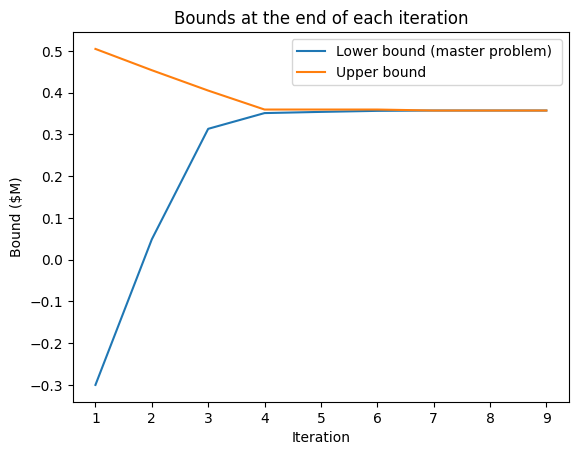

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(1,len(mp_obj_list)+1), np.array(mp_obj_list)/10**6,range(1,len(mp_obj_list)+1),np.array(UB_list)/10**6)
plt.title('Bounds at the end of each iteration')
plt.xlabel('Iteration')
plt.ylabel('Bound ($M)')
plt.legend(['Lower bound (master problem) ','Upper bound '])
plt.savefig('ben_mp.pdf')
plt.show()